<a href="https://colab.research.google.com/github/SRIBALAJI00/deeplearning-mini-project/blob/main/parkinsons_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (500, 12)

First few rows:
   Patient_ID  Age Gender  Years_Since_Diagnosis  UPDRS_Score  \
0           1   78      M                      5           41   
1           2   64      F                      3           52   
2           3   57      M                      5           21   
3           4   70      F                      5           19   
4           5   68      M                      5           57   

   Tremor_Severity  Motor_Function  Speech_Difficulty  Balance_Problems  \
0                3               2                  2                 3   
1                4               1                  2                 3   
2                1               0                  0                 5   
3                4               1                  3                 1   
4                3               0                  4                 3   

  Medications Exercise_Level  Disease_Progression  
0    Levodopa       Moderate                    2  
1  Amantadin

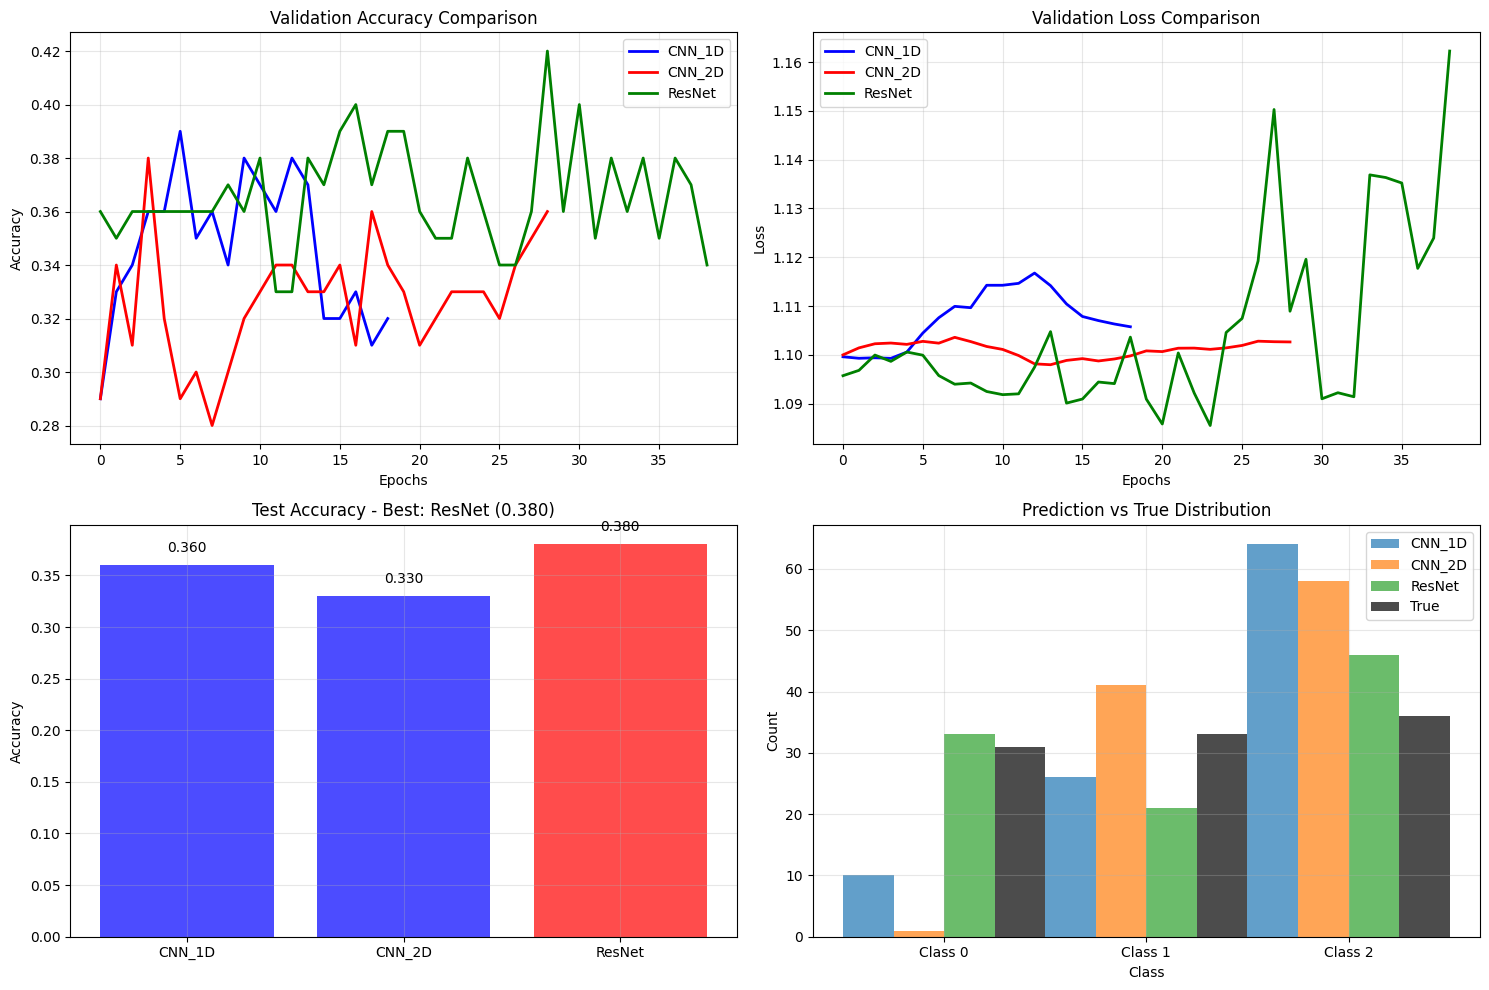


FINAL MODEL COMPARISON

CNN_1D:
  Final Training Accuracy: 0.3575
  Final Validation Accuracy: 0.3200
  Test Accuracy: 0.3600

CNN_2D:
  Final Training Accuracy: 0.3500
  Final Validation Accuracy: 0.3600
  Test Accuracy: 0.3300

ResNet:
  Final Training Accuracy: 0.5625
  Final Validation Accuracy: 0.3400
  Test Accuracy: 0.3800

 BEST PERFORMING MODEL: ResNet
 Test Accuracy: 0.3800

 LEARNING VERIFICATION:
CNN_1D: 3 unique predictions, mean entropy: 1.097
CNN_2D: 3 unique predictions, mean entropy: 1.092
ResNet: 3 unique predictions, mean entropy: 1.062


In [ ]:
# ===============================
# COMPREHENSIVE FIX FOR MULTI-CLASS PARKINSONS DATA
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# ===============================
# LOAD AND ANALYZE DATA
# ===============================
df = pd.read_excel("/content/parkinsons_data.csv.xlsx")
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# ===============================
# COMPREHENSIVE DATA ANALYSIS
# ===============================
print("\n" + "="*50)
print("DATA ANALYSIS")
print("="*50)

print("Target variable distribution:")
target_counts = df["Disease_Progression"].value_counts().sort_index()
print(target_counts)
print(f"Number of classes: {len(target_counts)}")

print("\nData types:")
print(df.dtypes)

# ===============================
# ENHANCED PREPROCESSING
# ===============================
X = df.drop(columns=["Patient_ID", "Disease_Progression"])
y = df["Disease_Progression"]

# Convert target to 0-indexed (1,2,3 -> 0,1,2)
y = y - 1  # Now classes are 0, 1, 2
num_classes = len(np.unique(y))
print(f"\nNumber of classes: {num_classes}")
print(f"Class distribution: {np.bincount(y)}")

# Handle categorical variables
categorical_cols = ["Gender", "Medications", "Exercise_Level"]
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        print(f"Encoded {col}: {len(le.classes_)} classes")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFeatures shape: {X_scaled.shape}")
print(f"Target unique values: {np.unique(y)}")

# ===============================
# HANDLE CLASS IMBALANCE
# ===============================
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"\nClass weights: {class_weight_dict}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}, Class distribution: {np.bincount(y_train)}")
print(f"Test set: {X_test.shape}, Class distribution: {np.bincount(y_test)}")

# ===============================
# CORRECTED MODEL ARCHITECTURES FOR MULTI-CLASS
# ===============================

def build_simple_cnn1d(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim, 1)),
        layers.Conv1D(32, kernel_size=2, activation="relu", padding='same'),  # Reduced kernel size
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),

        layers.Conv1D(64, kernel_size=2, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.4),

        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")  # Changed to softmax for multi-class
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",  # Changed loss function
                  metrics=["accuracy"])
    return model

def build_simple_cnn2d(input_dim, num_classes):
    side_length = int(np.ceil(np.sqrt(input_dim)))
    padding = side_length**2 - input_dim

    model = models.Sequential([
        layers.Input(shape=(side_length, side_length, 1)),

        layers.Conv2D(16, (2, 2), activation='relu', padding='same'),  # Reduced filters
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(32, (2, 2), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')  # Changed to softmax
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # Changed loss function
                  metrics=['accuracy'])
    return model

def build_simple_resnet(input_dim, num_classes):
    def res_block(x, filters, kernel_size=2):
        shortcut = x

        x = layers.Conv1D(filters, kernel_size, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Conv1D(filters, kernel_size, padding="same")(x)
        x = layers.BatchNormalization()(x)

        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv1D(filters, 1, padding="same")(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([shortcut, x])
        x = layers.ReLU()(x)
        return x

    inputs = layers.Input(shape=(input_dim, 1))

    x = layers.Conv1D(32, 2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = res_block(x, 32)
    x = res_block(x, 64)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)  # Changed to softmax

    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",  # Changed loss function
                  metrics=["accuracy"])
    return model

# ===============================
# DATA PREPARATION
# ===============================
side_length = int(np.ceil(np.sqrt(X_train.shape[1])))
padding = side_length**2 - X_train.shape[1]

print(f"\nData shapes:")
print(f"Original features: {X_train.shape[1]}")
print(f"Side length for 2D: {side_length}")
print(f"Padding needed: {padding}")

# 2D format
X_train_cnn2d = np.pad(X_train, ((0,0),(0,padding)), 'constant')
X_test_cnn2d = np.pad(X_test, ((0,0),(0,padding)), 'constant')
X_train_cnn2d = X_train_cnn2d.reshape(-1, side_length, side_length, 1)
X_test_cnn2d = X_test_cnn2d.reshape(-1, side_length, side_length, 1)

# 1D format
X_train_cnn1d = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn1d = X_test.reshape(-1, X_test.shape[1], 1)
X_train_resnet = X_train.reshape(-1, X_train.shape[1], 1)
X_test_resnet = X_test.reshape(-1, X_test.shape[1], 1)

print(f"CNN1D shape: {X_train_cnn1d.shape}")
print(f"CNN2D shape: {X_train_cnn2d.shape}")

# ===============================
# TRAINING WITH CORRECTED SETTINGS
# ===============================
EPOCHS = 100
BATCH_SIZE = 16

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1)
]

models_dict = {
    "CNN_1D": build_simple_cnn1d(X_train.shape[1], num_classes),
    "CNN_2D": build_simple_cnn2d(X_train.shape[1], num_classes),
    "ResNet": build_simple_resnet(X_train.shape[1], num_classes)
}

print("\n" + "="*50)
print("MODEL TRAINING")
print("="*50)

histories = {}
results = {}

for name, model in models_dict.items():
    print(f"\n🚀 Training {name}...")
    print(f"Model output shape: {model.output_shape}")

    if name == "CNN_2D":
        train_data = X_train_cnn2d
        test_data = X_test_cnn2d
    elif name == "CNN_1D":
        train_data = X_train_cnn1d
        test_data = X_test_cnn1d
    else:  # ResNet
        train_data = X_train_resnet
        test_data = X_test_resnet

    history = model.fit(
        train_data, y_train,
        validation_data=(test_data, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )

    histories[name] = history

    # Evaluate model
    test_loss, test_acc = model.evaluate(test_data, y_test, verbose=0)
    y_pred_prob = model.predict(test_data, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)  # Get class with highest probability

    results[name] = {
        "accuracy": test_acc,
        "loss": test_loss,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred),
        "predictions": y_pred,
        "prediction_probabilities": y_pred_prob
    }

    print(f"✅ {name} completed - Test Accuracy: {test_acc:.4f}")

# ===============================
# RESULTS ANALYSIS
# ===============================
print("\n" + "="*50)
print("DETAILED RESULTS ANALYSIS")
print("="*50)

for name, res in results.items():
    print(f"\n {name}:")
    print(f"Test Accuracy: {res['accuracy']:.4f}")
    print(f"Test Loss: {res['loss']:.4f}")
    print("Confusion Matrix:")
    print(res["confusion_matrix"])
    print("Classification Report:")
    print(res["classification_report"])

    # Prediction distribution analysis
    pred_dist = pd.Series(res['predictions']).value_counts().sort_index()
    print(f"Predictions distribution: {dict(pred_dist)}")
    print(f"True distribution: {dict(pd.Series(y_test).value_counts().sort_index())}")

# ===============================
# VISUALIZATION
# ===============================
plt.figure(figsize=(15, 10))

# Plot 1: Validation Accuracy Comparison
plt.subplot(2, 2, 1)
colors = {'CNN_1D': 'blue', 'CNN_2D': 'red', 'ResNet': 'green'}
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'],
             label=f"{name}",
             color=colors[name],
             linewidth=2)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Validation Loss Comparison
plt.subplot(2, 2, 2)
for name, history in histories.items():
    plt.plot(history.history['val_loss'],
             label=f"{name}",
             color=colors[name],
             linewidth=2)
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Final Test Accuracy
plt.subplot(2, 2, 3)
model_names = list(results.keys())
test_accuracies = [results[name]['accuracy'] for name in model_names]

# Find best model
best_idx = np.argmax(test_accuracies)
colors_bar = ['red' if i == best_idx else 'blue' for i in range(len(model_names))]

bars = plt.bar(model_names, test_accuracies, color=colors_bar, alpha=0.7)
plt.title(f'Test Accuracy - Best: {model_names[best_idx]} ({test_accuracies[best_idx]:.3f})')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

# Add values on bars
for bar, acc in zip(bars, test_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# Plot 4: Prediction Distribution Comparison
plt.subplot(2, 2, 4)
x_pos = np.arange(num_classes)
width = 0.25

for i, name in enumerate(model_names):
    pred_counts = [np.sum(results[name]['predictions'] == cls) for cls in range(num_classes)]
    plt.bar(x_pos + i*width, pred_counts, width, label=name, alpha=0.7)

true_counts = [np.sum(y_test == cls) for cls in range(num_classes)]
plt.bar(x_pos + len(model_names)*width, true_counts, width, label='True', alpha=0.7, color='black')

plt.title('Prediction vs True Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(x_pos + width*1.5, [f'Class {i}' for i in range(num_classes)])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===============================
# FINAL COMPARISON
# ===============================
print("\n" + "="*50)
print("FINAL MODEL COMPARISON")
print("="*50)

best_accuracy = 0
best_model = ""

for name in model_names:
    final_train_acc = histories[name].history['accuracy'][-1]
    final_val_acc = histories[name].history['val_accuracy'][-1]
    test_acc = results[name]['accuracy']

    print(f"\n{name}:")
    print(f"  Final Training Accuracy: {final_train_acc:.4f}")
    print(f"  Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")

    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model = name

print(f"\n BEST PERFORMING MODEL: {best_model}")
print(f" Test Accuracy: {best_accuracy:.4f}")

# Check if models are actually learning
print(f"\n LEARNING VERIFICATION:")
for name in model_names:
    unique_preds = len(np.unique(results[name]['predictions']))
    pred_entropy = -np.sum(results[name]['prediction_probabilities'] *
                          np.log(results[name]['prediction_probabilities'] + 1e-8)) / len(y_test)
    print(f"{name}: {unique_preds} unique predictions, mean entropy: {pred_entropy:.3f}")